# Introduction

This notebooks is intended to experiment with NLP Sentiment Analysis Text Classification task.

# Flair

In [5]:
# Import Standard Libraries
import flair

In [6]:
# Define input sentence
input_text = 'I like you!'
input_text_2 = "I hate it when I'm not learning"

In [7]:
# Tokenize the input through Flair
input_text_tokens = flair.data.Sentence(input_text)
input_text_2_tokens = flair.data.Sentence(input_text_2)

In [8]:
input_text_tokens.to_tokenized_string()

'I like you !'

In [9]:
# Initialise the model "Distillbert"
model_flair = flair.models.TextClassifier.load('en-sentiment')

In [10]:
# Predict the sentiment
model_flair.predict(input_text_tokens)
model_flair.predict(input_text_2_tokens)

In [11]:
# Extract rating
print('Sentiment: {}'.format(input_text_2_tokens.get_labels()[0].value))
print('Score: {}'.format(input_text_2_tokens.get_labels()[0].score))

Sentiment: NEGATIVE
Score: 0.9991464614868164


# Finbert

The model would be [ProsusAI/finbert](https://huggingface.co/ProsusAI/finbert) from **Hugging Face**, which is specialized in financial text. 

In [12]:
# Import Standard Libraries
from transformers import BertTokenizer
from transformers import AutoModelForSequenceClassification

import torch.nn.functional as F
import torch

In [13]:
# Input text (Investing Subreddit post)
input_text_finbert_1 = ("Given the recent downturn in stocks especially in tech which is likely to persist as yields keep going up, "
                        "I thought it would be prudent to share the risks of investing in ARK ETFs, written up very nicely by "
                        "[The Bear Cave](https://thebearcave.substack.com/p/special-edition-will-ark-invest-blow). The risks comes "
                        "primarily from ARK's illiquid and very large holdings in small cap companies. ARK is forced to sell its "
                        "holdings whenever its liquid ETF gets hit with outflows as is especially the case in market downturns. "
                        "This could force very painful liquidations at unfavorable prices and the ensuing crash goes into a "
                        "positive feedback loop leading into a death spiral enticing even more outflows and predatory shorts.")

In [14]:
# Instance a Bert Tokenizer
# NOTE: Transformers might need the appropriate tokenizer for preparing the input data
bert_tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

In [15]:
# Tokenize the Finbert input
tokens_finbert_1 = bert_tokenizer.encode_plus(input_text_finbert_1, 
                                              max_length=512, # Max token length
                                              truncation=True, # If sequence is bigger, drop it
                                              padding='max_length', #
                                              add_special_tokens=True, # CLS = 101, SEP = 102, MASK = 103, UNK = 100, PAD = 0
                                              return_tensors='pt') # PyTorch Tensor

In [16]:
# Initialise the Finbert model
model_finbert = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

In [17]:
# Finbert Inference - Compute the activations
output_finbert_1 = model_finbert(**tokens_finbert_1)

In [18]:
# In order to have probs from the activations, we need to pass them through an acitvation function
output_finbert_1

SequenceClassifierOutput(loss=None, logits=tensor([[-1.8200,  2.4484,  0.0216]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [19]:
# Apply the Softmax function to all the dimensions of the input tensor
probs = F.softmax(output_finbert_1[0], dim=-1)

In [20]:
# Reitreve max prob
prediction = torch.argmax(probs)

print(prediction.item())

1


# Kaggle Movie Reviews

The data is from Kaggle and can be found [here](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data).

## Read Data

In [1]:
# Import Standard Libraries
import pandas as pd
import numpy as np

from transformers import BertTokenizer
from transformers import TFAutoModel

import tensorflow as tf

/Users/s.porreca/.local/share/virtualenvs/cheat_sheets-EiW5VkhA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-13 20:36:25.784641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  Read data
movie_reviews_train = pd.read_csv('./../../../data/movie_reviews_train.tsv', sep='\t')

In [3]:
movie_reviews_train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


## Data Preparation

In [4]:
# Drop duplicates and keep only single sentence (you can see they are repeated)
movie_reviews_train = movie_reviews_train.drop_duplicates('SentenceId', keep='first')

<Axes: >

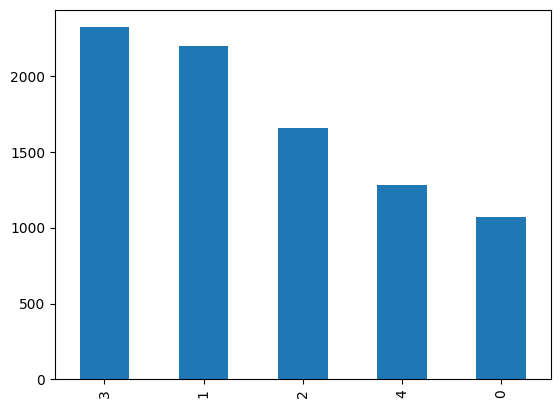

In [5]:
# Check the distribution of the Sentiment (0: negative - 4: positive)
movie_reviews_train['Sentiment'].value_counts().plot(kind='bar')

In [6]:
# Tokenize with Bert
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# In latest version is better to call "tokenizer" itself instead of "encode_plus" function
movie_reviews_train_tokens = tokenizer(movie_reviews_train['Phrase'].tolist(),
                                       max_length=512,
                                       truncation=True,
                                       padding='max_length',
                                       add_special_tokens=True,
                                       return_tensors='np')

In [7]:
movie_reviews_train_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

**NOTE:** 

THe `attention_mask` is used in order to exclude from the computation the `[PAD]` special tokens.
Consider the following example.

*Input Sequence*: "This is a short sentence" &rarr; It has 5 tokens/words &rarr; If the max token length is 8 &rarr; ["this", "is", "a", "short", sentence", [PAD], [PAD], [PAD]] &rarr; *Attention Mask*: [1, 1, 1, 1, 1, 0, 0, 0], because the last tokens are padding and thus not relevant.

In [8]:
# Save the tokens in a binary file
with open('./../tensors/movie-xids.npy', 'wb') as file:
    np.save(file, movie_reviews_train_tokens['input_ids'])
with open('./../tensors/movie-xmask.npy', 'wb') as file:
    np.save(file, movie_reviews_train_tokens['attention_mask'])

In [9]:
# Extract labels
labels = movie_reviews_train['Sentiment'].values

# Retrieve number of labels
num_labels = labels.max() + 1

# Retrieve number of data points
num_samples = len(movie_reviews_train)

# Initialise empty one-hot labels encoded matrix
labels_encoded = np.zeros((num_samples, num_labels))

# One-hot encode the labels
labels_encoded[np.arange(num_samples), labels] = 1

In [10]:
labels

array([1, 4, 1, ..., 1, 1, 2])

In [11]:
labels_encoded

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [12]:
# Save the labels
with open('./../tensors/movie-labels.npy', 'wb') as file:
    np.save(file,labels_encoded )

## Load Data

In [13]:
# Load tensors previously saved
with open('./../tensors/movie-xids.npy', 'rb') as file:
    xids = np.load(file, allow_pickle=True)
with open('./../tensors/movie-xmask.npy', 'rb') as file:
    xmask = np.load(file, allow_pickle=True)
with open('./../tensors/movie-labels.npy', 'rb') as file:
    labels = np.load(file, allow_pickle=True)

## Create TensorFlow Dataset

In [14]:
# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((xids, xmask, labels))

In [15]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [16]:
def mapping_function(input_ids, attention_masks, labels):
    """
    Format the input in the right format for TensorFlow Network
    Convert our three-item tuple into a two-item tuple where the input item is a dictionary {input_ids, attention_mask}, output
    """
    return {'input_ids': input_ids, 'attention_mask': attention_masks}, labels

In [17]:
# Apply the reformat to the whole dataset
dataset = dataset.map(mapping_function)

dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [18]:
# Define Shuffle and Batch
dataset = dataset.shuffle(10000)
dataset = dataset.batch(batch_size=16, drop_remainder=True)

In [19]:
# Note the batch size of 16
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [20]:
# Split in train & test data
split_size = int((xids.shape[0] / 16) * 0.9)

train_data = dataset.take(split_size)
validation_data = dataset.skip(split_size)

In [21]:
# Save datasets
tf.data.Dataset.save(train_data, './../datasets/movie_rating_train')
tf.data.Dataset.save(validation_data, './../datasets/movie_rating_validation')

In [22]:
train_data.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

## Load TensorFlow Dataset

In [23]:
train_dataset = tf.data.Dataset.load('./../datasets/movie_rating_train')
validation_dataset = tf.data.Dataset.load('./../datasets/movie_rating_validation')

## Model Development

A TensorFlow version of the BERT model is adopted.

In order to use it as a classifier, there is the need to add a couple of Dense layer as head to the top of the BERT architecture, and a couple of input layers to feed the data in input.

In [24]:
# Instance model
tf_bert_model = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [25]:
tf_bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Define the Neural Network Architecture
# Define two input layers: one for input_ids and one for attention_masks (NOTE: BERT layer wants tensors and not input layers, that's why tf.keras.Input and not tf.keras.layers.InputLayer)
input_ids_input_layer = tf.keras.Input(shape=(512,), # 512 comes from the token size / It does not include batch size
                                       name='input_ids',
                                       dtype='int32')

attention_mask_input_layer = tf.keras.Input(shape=(512,), # 512 comes from the token size
                                            name='attention_mask',
                                            dtype='int32')

# Pass the Output of the input layers to the "bert" layer and retrieve the embeddings of the sentences
embeddings_layer = tf_bert_model.bert(input_ids_input_layer, attention_mask=attention_mask_input_layer)[1]  # [1] Access the max-pooled activations and not the raw activations

# Add Dense layers for classificaiton purposes
dense_layer_1 = tf.keras.layers.Dense(1024, activation='relu')(embeddings_layer)
output = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(dense_layer_1)

In [27]:
# Construct the model
model = tf.keras.Model(inputs=[input_ids_input_layer, attention_mask_input_layer], outputs=output)

In [28]:
# Freeze the 'bert' layer, so to not train it
model.layers[2].trainable = False

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

## Model Training

In [30]:
# Define training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [31]:
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

In [32]:
# Train model
# NOTE: Let's reduce the data samples in order to speed it up a little bit
history = model.fit(train_dataset.take(1000), 
                    validation_data=validation_dataset.take(10), 
                    steps_per_epoch=10,
                    epochs=3)

Epoch 1/3


10/10 [==============================] - 170s 17s/step - loss: 1.7315 - accuracy: 0.1750 - val_loss: 1.6192 - val_accuracy: 0.2250
Epoch 2/3
10/10 [==============================] - 165s 17s/step - loss: 1.5226 - accuracy: 0.3063 - val_loss: 1.5745 - val_accuracy: 0.3438
Epoch 3/3
10/10 [==============================] - 170s 18s/step - loss: 1.5427 - accuracy: 0.2937 - val_loss: 1.5419 - val_accuracy: 0.3375


In [33]:
# Save model
model.save('./../models/movie_ratings_bert_model')

INFO:tensorflow:Assets written to: ./../models/movie_ratings_bert_model/assets


INFO:tensorflow:Assets written to: ./../models/movie_ratings_bert_model/assets


## Inference

In [2]:
# Load model
model = tf.keras.models.load_model('./../models/movie_ratings_bert_model')

In [4]:
# Instance the tokenizer again (just for not go back in the notebook)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [5]:
def process_input_data(data):
    """
    Process input data for inference through the BERT model
    """

    # Create tokens
    tokens = tokenizer(data,
                       max_length=512,
                       truncation=True,
                       padding='max_length',
                       add_special_tokens=True,
                       return_tensors='tf')
    
    # Format input
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [13]:
probabilities = model.predict(process_input_data('This movie is amazing and incredible and fantastic'))

1/1 [==============================] - 1s 629ms/step


In [14]:
np.argmax(probabilities[0])

1